In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import probfit
import iminuit
from scipy.stats import norm

from probfit import UnbinnedLH
from probfit import gaussian
from iminuit import Minuit



In [2]:
original_df=pd.read_hdf("/mnt/t3nfs01/data01/shome/micheli/energyRegProject_20180223/CMSSW_8_0_4/src/RegressionTraining/applyRegression/ntuples_NN/Ntup_10Nov_Photon_testing.hd5")
#original_df_EE=pd.read_hdf("/mnt/t3nfs01/data01/shome/micheli/energyRegProject_20180223/CMSSW_8_0_4/src/RegressionTraining/applyRegression/ntuples_NN_EE/Ntup_10Nov_Photon_testing_EE.hd5")
print("finished")

Opening /mnt/t3nfs01/data01/shome/micheli/energyRegProject_20180223/CMSSW_8_0_4/src/RegressionTraining/applyRegression/ntuples_NN/Ntup_10Nov_Photon_testing.hd5 in read-only mode
finished


In [81]:
column='pt'
lower_bound=0.8
upper_bound=1.2

df=original_df.copy()
df=df[df['response']>lower_bound]
df=df[df['response']<upper_bound]
df.loc[:,'response']=np.reciprocal(df.loc[:,'response'].values) #invert response
df=df[np.abs(df[column]-df[column].median()) <= (2*df[column].std())]#outlier detection

In [82]:
x_plot=[]
y_plot=[]
y_err=[]
y_err_fit=[]
y_err_sigma=[]
notused,bins=pd.cut(df[column],30,retbins=True)#todo: Add errors in histogramm and ratio sqrt(entries)

/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: LogWarning: x is really small return 0


FCN = 71085.8314122 
 TOTAL NCALL = 16 
 NCALLS = 16 
 
 
 EDM = 3.7101555231e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.533878,0.000675518,,,0.3,0.9,No
1,n,3,0.1,,,,,Yes
2,mean,0.993402,0.01,,,0.9,1.05,Yes
3,sigma,0.00745299,1,,,0.001,0.091,Yes


/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: InitialParamWarning: Parameter alpha is floating but does not have initial step size. Assume 1.
/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: InitialParamWarning: Parameter n is floating but does not have initial step size. Assume 1.
/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: LogWarning: x is really small return 0
Exception ZeroDivisionError: 'float division' in 'probfit._libstat.xlogyx' ignored
Exception ZeroDivisionError: 'float division' in 'probfit._libstat.xlogyx' ignored
Exception ZeroDivisionError: 'float division' in 'probfit._libstat.xlogyx' ignored
Exception ZeroDivisionError: 'float division' in 'probfit._libsta

FCN = 38300.4828811 
 TOTAL NCALL = 193 
 NCALLS = 193 
 
 
 EDM = 1.57067838857e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.302965,0.000823361,,,,,No
1,n,20.4217,0.584895,,,,,No
2,mean,0.996854,1.5758e-05,,,,,No
3,sigma,0.00745299,1,,,,,Yes


/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: InitialParamWarning: Parameter alpha is floating but does not have initial step size. Assume 1.
/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: LogWarning: x is really small return 0
Exception ZeroDivisionError: 'float division' in 'probfit._libstat.xlogyx' ignored
Exception ZeroDivisionError: 'float division' in 'probfit._libstat.xlogyx' ignored
Exception ZeroDivisionError: 'float division' in 'probfit._libstat.xlogyx' ignored


FCN = 38300.4828811 
 TOTAL NCALL = 35 
 NCALLS = 35 
 
 
 EDM = 9.00772525298e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.302965,0.000356905,,,,,No
1,n,20.4217,1,,,,,Yes
2,mean,0.996854,1.45429e-05,,,,,No
3,sigma,0.00745299,1,,,,,Yes


/mnt/t3nfs01/data01/swshare/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.


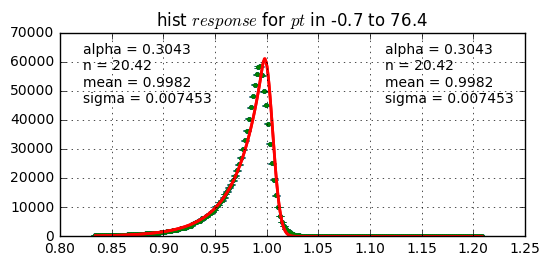

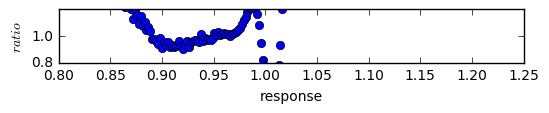

In [93]:
#for original_df in [original_df1,original_df_EE]:

    #if k==0:
      #  suffix='NN'
        #k+=1
   # else:
     #   suffix='NN_EE'
    

fit_upper=1.1
fit_lower=0.9
for i in xrange(0,len(bins)-1):
        df_temp=df[df[column] >=bins[i]]
        df_temp=df_temp[df_temp[column]<=bins[i+1]]
        bound = (fit_lower, fit_upper)
        bound_fit=(0.98,1.01)
            
        ax=plt.subplot2grid((6,3),(0,0), rowspan=4,colspan=4)    
        data=df_temp.loc[:,'response'].astype(float).values
        data_gaussian=df_temp[(df_temp['response']>bound_fit[0] )&
                              (df_temp['response']<bound_fit[1])].loc[:,'response'].astype(float).values
        mu,sigma=norm.fit(data_gaussian)

        normalized_crystalball = probfit.Normalized(probfit.crystalball, bound)
        binned_likelihood = probfit.BinnedLH(normalized_crystalball, data,bins=200)
        
        
        
         
        minuit = iminuit.Minuit(binned_likelihood, alpha=.5, error_alpha=0.05,
                                limit_alpha=(0.3,0.9),n=3.,error_n=0.1, mean=mu,error_mean=0.01,
                                limit_mean=(0.9,1.05),  sigma=sigma, fix_sigma=True,fix_mean=True,fix_n=True,limit_sigma=(0.001,0.091))
        minuit.migrad()
        
        coeff=minuit.args
        minuit = iminuit.Minuit(binned_likelihood,alpha=coeff[0],n=coeff[1],mean=coeff[2],sigma=coeff[3]
                                ,fix_sigma=True)
        minuit.migrad()         
        coeff=minuit.args
        
        
        minuit = iminuit.Minuit(binned_likelihood,alpha=coeff[0],n=coeff[1],mean=coeff[2],sigma=coeff[3],
                                fix_sigma=True,fix_n=True,)
        minuit.migrad() 
        coeff=minuit.args
        
        minuit = iminuit.Minuit(binned_likelihood,alpha=coeff[0],n=coeff[1],mean=coeff[2],sigma=coeff[3],
                               fix_sigma=True,fix_n=True,fix_alpha=True)


        




        plt.title("hist $response$ for ${}$ in {} to {}".format(column,int(10*bins[i])/10.,int(10*bins[i+1])/10.))
        
        (data_edges, datay), (errorp, errorm), (total_pdf_x, total_pdf_y),parts=binned_likelihood.draw(
        parmloc=((0.7,0.95)),nfbins=201)
        binned_likelihood.show()
        coeff=minuit.args
        y_plot.append(coeff[2])
        x_plot.append(df_temp[column].values[np.argmin(df_temp['response'].values-coeff[2])])
        y_err_fit.append(minuit.errors[2])
        y_err_sigma.append(coeff[3])
        

        plt.subplot2grid((5,3),(4,0),rowspan=2,colspan=4).set_yticks([0.8,1])
        ratio=datay/total_pdf_y
        plt.ylim(0.8,1.2)
        plt.plot((data_edges[1:]+data_edges[:-1])/2,ratio,'bo')
        #unbinned_likelihood.draw_residual(minuit,parmloc=(0.7,0.95))
        plt.ylabel(r"$ratio$")
        plt.xlabel("response")
        

        #plt.savefig("plots/CB_{}/{}_{}".format(column,suffix,i)) 
        plt.show()
        break


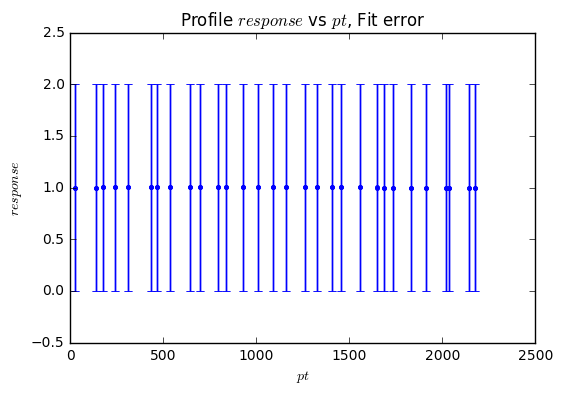

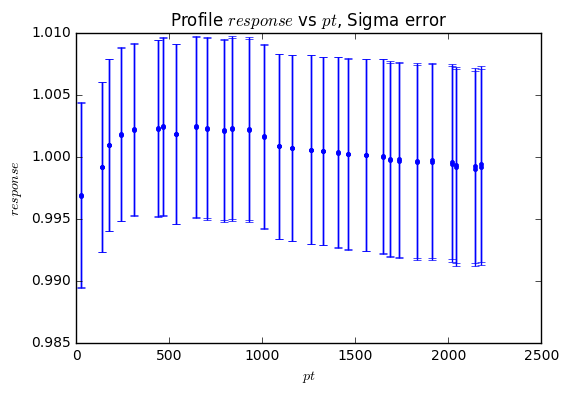

In [92]:
suffix='NN'
plt.figure()
plt.title("Profile $response$ vs ${}$, Fit error".format(column))
plt.ylabel(r"$response$")
plt.xlabel(r"${}$".format(column))
plt.errorbar(x_plot,y_plot,y_err_fit,fmt='b.')
plt.savefig("plots/profile_plots_response/Fit_Error_{}response_vs_{}".format(suffix,column))
plt.show()
plt.close()
plt.figure()
plt.title("Profile $response$ vs ${}$, Sigma error".format(column))
plt.ylabel(r"$response$")
plt.xlabel(r"${}$".format(column))
plt.errorbar(x_plot,y_plot,y_err_sigma,fmt='b.')
plt.savefig("plots/profile_plots_response/Sigma_Error_{}response_vs_{}".format(suffix,column))
plt.show()
plt.close()